# First iteration of tree-based models.

The hyperparameter optization process will be the following:
1. Train with default hyperaparameters.
2. Identify bias and variance.
3. Choose first range for hyperparameters based on results.
4. Train n models using HalvingRandomSearchCV from scikit learn.
5. Pick the regions of the hyperparameter space that yield the best results.
6. Centre the hyperparameter search on those regions and iterate.

The scoring will consist in:
1. Numerical scores for the testing subset: recall, precision, roc_auc, f1.
2. Numerical scores for the whole data: recall, precision, roc_auc, f1.
2. Visualization of the ROC curve for the whole data.
4. Confusion matrix for the whole data.

In this way we can see if each model over/underfits, comparing the test and total scores. Also, the ROC curve and the confusion matrix will show how each model is performing in the whole dataset.


In [30]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# For random number generation
from scipy.stats import randint, uniform

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold, HalvingGridSearchCV

# Some auxiliary functions for scoring.
import scoring_utils

#DEV
import importlib as imp


In [3]:
# Import the dataframe cleaned and encoded during the feature importance process.
df_encoded = pd.read_csv('../data/df_encoded.csv')

In [4]:
target = 'Default'
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
# Our target and features are the same that we employed during the importance analysis.
print(f"Target: {target}")
print(f"Features: {features_encoded}")

Target: Default
Features: ['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isNewBusiness', 'isFranchise', 'SBARatio', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [5]:
# This split will be used in every model, so that they are scored against the same subset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)
# Complete datasets
X_total = df_encoded[features_encoded]
y_total = df_encoded[target]

### Single Decision Tree Classifier

In [8]:
# Default check to identify bias/variance
from sklearn.tree import DecisionTreeClassifier

default_tree = DecisionTreeClassifier()
default_tree.fit(X_train, y_train)

yhat_train = default_tree.predict(X_train)
yhat_test = default_tree.predict(X_test)

default_tree_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Tree Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Tree Test")
    ))

default_tree_score

,Recall,Precision,ROC,F1
Default Tree Train,0.974608,0.997159,0.987017,0.985755
Default Tree Test,0.749900,0.761325,0.850624,0.755569


In [9]:
default_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

It does overfit! Let's decrease the variance by tuning the hyperparameters.

In [10]:

# Grid of parameters for a single tree
param_grid = [
    {
        "min_samples_split": randint(100, 200),
        "max_depth": randint(14, 18)
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingRandomSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    n_candidates=1000
)

single_tree_search.fit(X_train, y_train)


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=DecisionTreeClassifier(), n_candidates=1000,
                      n_jobs=-1,
                      param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16c0f00d0>,
                                            'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2870efd90>}],
                      scoring='recall')

In [11]:
scoring_utils.get_best_kernels(single_tree_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
14_172,"{'max_depth': 14, 'min_samples_split': 172}",1,0.715041
17_173,"{'max_depth': 17, 'min_samples_split': 173}",2,0.712682
17_173,"{'max_depth': 17, 'min_samples_split': 173}",3,0.669584
14_172,"{'max_depth': 14, 'min_samples_split': 172}",3,0.669584
15_178,"{'max_depth': 15, 'min_samples_split': 178}",5,0.668484
...,...,...,...
17_103,"{'max_depth': 17, 'min_samples_split': 103}",171,0.000000
17_194,"{'max_depth': 17, 'min_samples_split': 194}",171,0.000000
15_138,"{'max_depth': 15, 'min_samples_split': 138}",171,0.000000


In [12]:
# Let's use the best estimator to obtain test and overall scores 
single_tree_model = single_tree_search.best_estimator_

yhat_test = single_tree_model.predict(X_test)
yhat_total = single_tree_model.predict(X_total)

In [13]:
single_tree_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Single Tree Test")
single_tree_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Single Tree Total")

single_tree_score = pd.concat((single_tree_test_score, single_tree_total_score))
single_tree_score

,Recall,Precision,ROC,F1
Single Tree Test,0.790165,0.834737,0.878895,0.811840
Single Tree Total,0.803370,0.845325,0.886475,0.823814


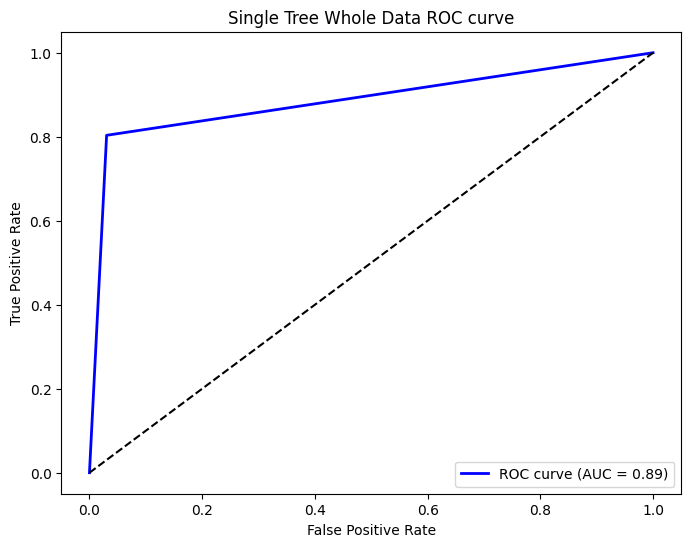

In [15]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Single Tree Whole Data")

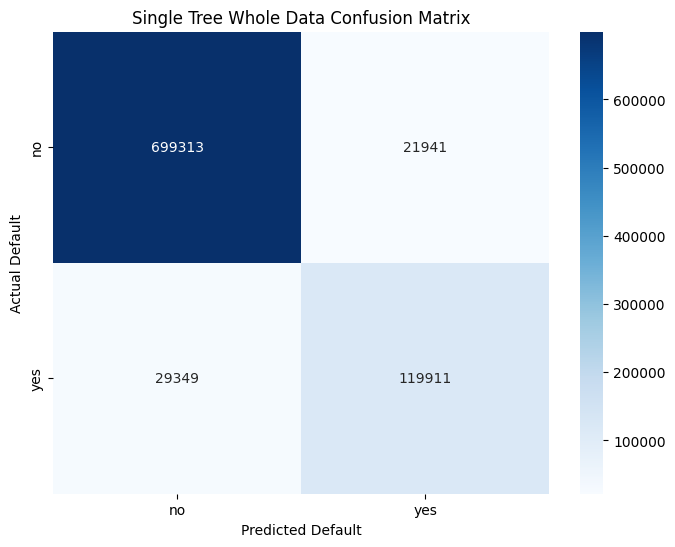

In [16]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Single Tree Whole Data")

### Bagging classifier

In [17]:
# Default check to identify bias/variance
from sklearn.ensemble import BaggingClassifier

default_bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1)
default_bagging.fit(X_train, y_train)

yhat_train = default_bagging.predict(X_train)
yhat_test = default_bagging.predict(X_test)

default_bagging_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Bagging Test")
    ))

default_bagging_score

,Recall,Precision,ROC,F1
Default Bagging Train,0.956288,0.983735,0.976508,0.969817
Default Bagging Test,0.773483,0.811086,0.868100,0.791838


In [18]:
default_bagging.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [43]:
# Default check to identify bias/variance
from sklearn.ensemble import BaggingClassifier

manual_bagging = BaggingClassifier(single_tree_model,
                                   n_jobs=-1,
                                   n_estimators=10,
                                   max_samples=.9)
manual_bagging.fit(X_train, y_train)

yhat_train = manual_bagging.predict(X_train)
yhat_test = manual_bagging.predict(X_test)

manual_bagging_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Manual Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Manual Bagging Test")
    ))

manual_bagging_score

,Recall,Precision,ROC,F1
Manual Bagging Train,0.804420,0.846177,0.887079,0.824770
Manual Bagging Test,0.793448,0.837198,0.880759,0.814736


In [50]:

# Grid of parameters for a single tree
param_grid = [
    {
        "max_samples": [.8, .9, 1.0]
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

bagging_search = HalvingGridSearchCV(
    estimator=BaggingClassifier(n_estimators=10, estimator=single_tree_model),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

bagging_search.fit(X_train, y_train)


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 261154
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 261154
Fitting 9 folds for each of 3 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 1
n_resources: 783462
Fitting 9 folds for each of 1 candidates, totalling 9 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                                                 min_samples_split=172)),
                    n_jobs=-1, param_grid=[{'max_samples': [0.8, 0.9, 1]}],
                    scoring='recall', verbose=1)

In [52]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
0.9,{'max_samples': 0.9},1,0.795085
0.9,{'max_samples': 0.9},2,0.783319
0.8,{'max_samples': 0.8},3,0.783252
1,{'max_samples': 1},4,0.000000


In [53]:
bagging_model = bagging_search.best_estimator_

yhat_test = bagging_model.predict(X_test)
yhat_total = bagging_model.predict(X_total)

In [54]:
bagging_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Bagging Test")
bagging_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Bagging Total")

bagging_score = pd.concat((bagging_test_score, bagging_total_score, single_tree_score))
bagging_score

,Recall,Precision,ROC,F1
Bagging Test,0.793917,0.838167,0.881097,0.815442
Bagging Total,0.803430,0.845561,0.886531,0.823957
Single Tree Test,0.790165,0.834737,0.878895,0.811840
Single Tree Total,0.803370,0.845325,0.886475,0.823814


In [19]:
yhat_baseline = pd.read_csv('../data/baseline_predict.csv')
scoring_utils.get_metrics(y_total, yhat_baseline, "Baseline")

,Recall,Precision,ROC,F1
Baseline,0.789368,0.83201,0.878192,0.810128


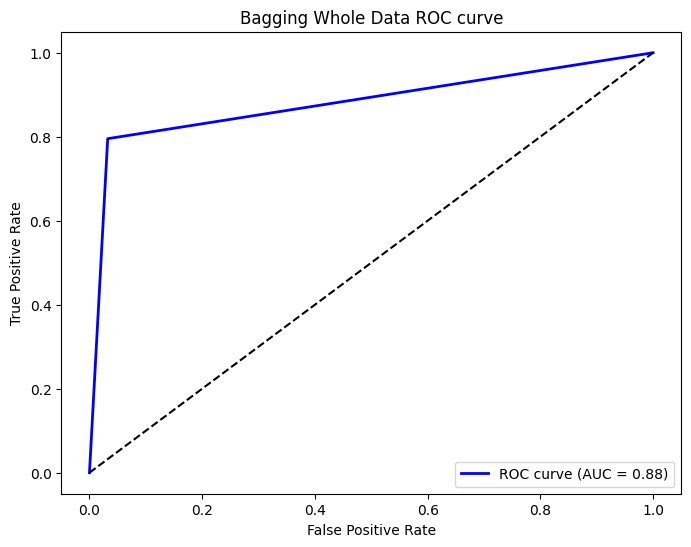

In [21]:
scoring_utils.get_roc_plot(y_test, yhat_test, "Bagging Whole Data")

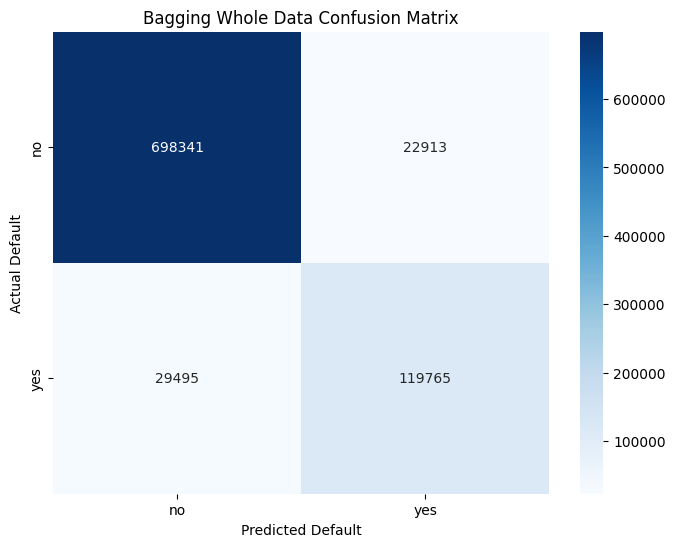

In [22]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")

### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

# {'max_depth': 14, 'min_samples_split': 109} # One of my best trees!!!!!

param_grid = {
    'max_depth': randint(12, 16),
    'min_samples_split': randint(100, 200),
    'n_estimators': randint(100, 500)
}

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

random_forest_search = HalvingRandomSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    n_candidates=50
)

random_forest_search.fit(X_train, y_train)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 10
min_resources_: 36
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 36
Fitting 9 folds for each of 50 candidates, totalling 450 fits


/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/s

----------
iter: 1
n_candidates: 17
n_resources: 108
Fitting 9 folds for each of 17 candidates, totalling 153 fits
----------
iter: 2
n_candidates: 6
n_resources: 324
Fitting 9 folds for each of 6 candidates, totalling 54 fits
----------
iter: 3
n_candidates: 2
n_resources: 972
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=RandomForestClassifier(), n_candidates=50,
                      n_jobs=-1,
                      param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15151bb10>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15791fe90>,
                                           'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157957510>},
                      scoring='recall', verbose=1)

In [24]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
13_123_222,"{'max_depth': 13, 'min_samples_split': 123, 'n_estimators': 222}",1,0.0
13_139_269,"{'max_depth': 13, 'min_samples_split': 139, 'n_estimators': 269}",1,0.0
14_193_484,"{'max_depth': 14, 'min_samples_split': 193, 'n_estimators': 484}",1,0.0
13_188_328,"{'max_depth': 13, 'min_samples_split': 188, 'n_estimators': 328}",1,0.0
12_170_398,"{'max_depth': 12, 'min_samples_split': 170, 'n_estimators': 398}",1,0.0
...,...,...,...
14_119_325,"{'max_depth': 14, 'min_samples_split': 119, 'n_estimators': 325}",1,0.0
12_105_196,"{'max_depth': 12, 'min_samples_split': 105, 'n_estimators': 196}",1,0.0
14_142_285,"{'max_depth': 14, 'min_samples_split': 142, 'n_estimators': 285}",1,0.0


In [33]:
##### DEV

forest_alt =  BaggingClassifier(
    n_estimators= 100,
    estimator=single_tree_model
)

forest_alt.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                   min_samples_split=109),
                  n_estimators=100)

In [34]:
###### DEV

yhat_alt = forest_alt.predict(X_total)

scoring_utils.get_metrics(y_total, yhat_alt, "Alternative")

,Recall,Precision,ROC,F1
Alternative,0.802459,0.839595,0.885366,0.820607


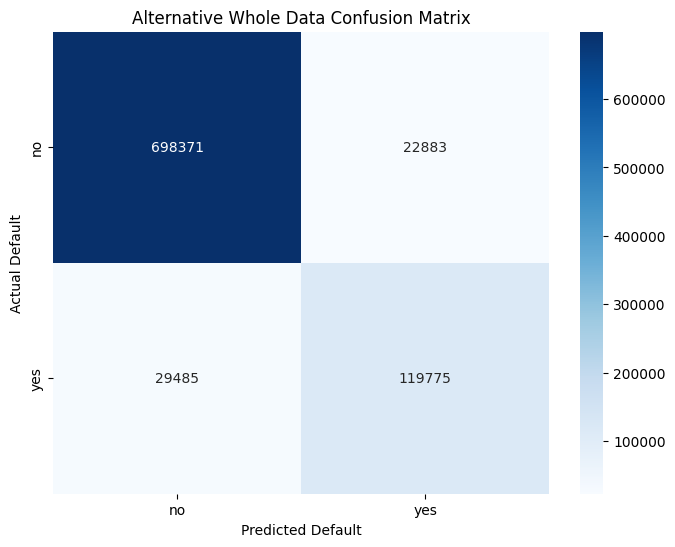

In [35]:
scoring_utils.get_confusion_matrix(y_total, yhat_alt, "Alternative Whole Data")

In [25]:
# Let's use the best estimator to obtain test and overall scores 
random_forest = bagging_search.best_estimator_

yhat_test = random_forest.predict(X_test)
yhat_total = random_forest.predict(X_total)

In [27]:
forest_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Random Forest Test")
forest_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Random Forest Total")

forest_score = pd.concat((forest_test_score, forest_total_score, bagging_score))
forest_score

,Recall,Precision,ROC,F1
Random Forest Test,0.578990,0.763440,0.770988,0.658543
Random Forest Total,0.584376,0.766346,0.773752,0.663104
Bagging Test,0.795339,0.835285,0.881491,0.814822
Bagging Total,0.802392,0.839408,0.885312,0.820482
Single Tree Test,0.791913,0.828124,0.879002,0.809614
Single Tree Total,0.801038,0.836374,0.884304,0.818325


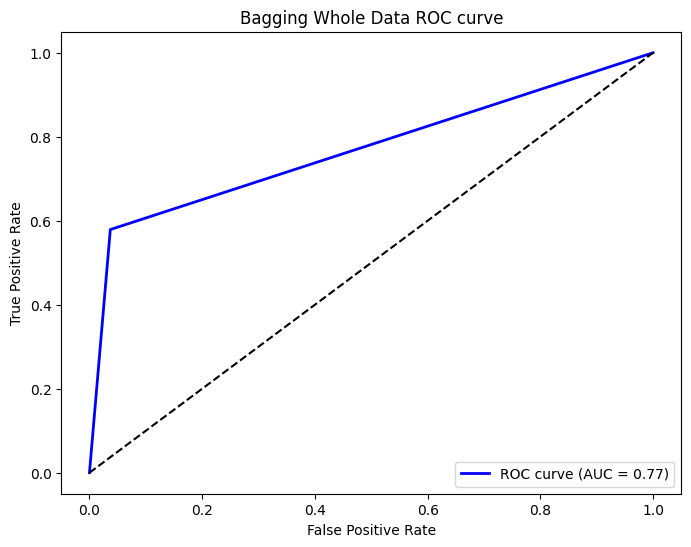

In [28]:
scoring_utils.get_roc_plot(y_test, yhat_test, "Bagging Whole Data")

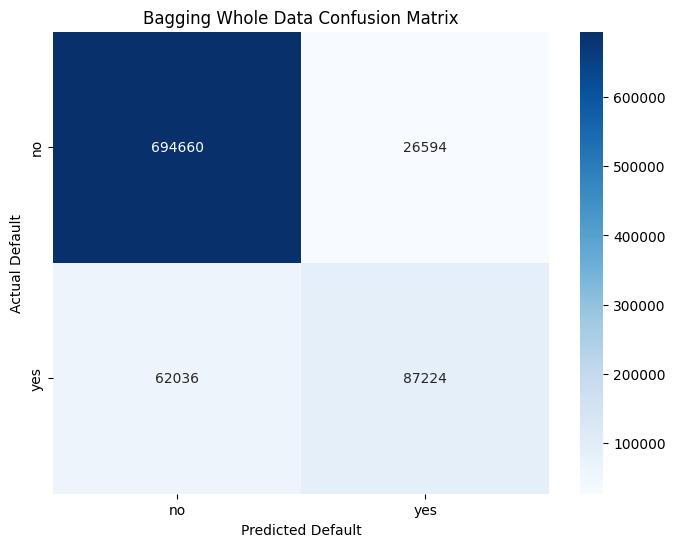

In [29]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")